# Recracking the Coding Interview
Rohit Das, Vinnie Khanna, Raj Srivastava

## Imports

In [2]:
%%bash
pip install tqdm transformers eli5 wordcloud

  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import imblearn
from tqdm import tqdm
import transformers
import matplotlib.pyplot as plt
from matplotlib.axes import Axes as ax
% matplotlib inline

import heapq as hq
from wordcloud import WordCloud

### Drive Mounting

In [ ]:
### Toggle True or False for Colab or Git Environment
COLABMODE = True

In [ ]:
from google.colab import drive
if COLABMODE:
   drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls
%cd drive/MyDrive/CS4650

drive/  sample_data/
/content/drive/.shortcut-targets-by-id/1uqNlsT-iMvXwO5u7llVBW7sH5wWwmT5t/CS4650


In [ ]:
### Once scraping is finished, this is how we'll load data
df_lc = pd.read_csv('cleaned_data_lc.csv')
df_cf = pd.read_csv('cleaned_data_codeforces.csv')
df_combined = pd.read_csv('cleaned_data_combined.csv')

##Data Processing

### Toy Dataset

In [ ]:
# idx: text, difficulty, category, time complexity
USE_EXAMPLE = False

if USE_EXAMPLE:
  example = {'text': ['Given an array of integers nums and an integer target, return indices of the two numbers such that they add up to target.\
   You may assume that each input would have exactly one solution, and you may not use the same element twice. You can return the answer in any order.',

    'Given two sorted arrays nums1 and nums2 of size m and n respectively, return the median of the two sorted arrays.',

    'You are given two non-empty linked lists representing two non-negative integers. The digits are stored in reverse order, \
    and each of their nodes contains a single digit. Add the two numbers and return the sum as a linked list. \
    You may assume the two numbers do not contain any leading zero, except the number 0 itself.',

    'Given a string s, return the longest palindromic substring in s.',

    'Given an array nums of distinct integers, return all the possible permutations. You can return the answer in any order.'
    ], 
    
    'difficulty': ['Easy', 'Hard', 'Medium', 'Medium', 'Medium'], 
    
    'category': ['hash map', 'binary search', 'linked list', 'dynamic programming', 'backtracking'], 
    
    'time_complexity': ['O(n)', 'O(log(n))', 'O(n)', 'O(n)', 'O(n!)']}
  data = pd.DataFrame(example)

  text = data.text.values
  print(text)

### Data Analysis

#### Difficulty

In [ ]:
pd.set_option('max_colwidth', 25)
print(df_combined.iloc[0], "\n")
print(df_combined.iloc[-2], "\n")

Unnamed: 0                            0
id                                    1
title                           Two Sum
title_slug                      two-sum
difficulty                            1
description    Given an array of int...
topics                Array, Hash Table
runtime                               n
Name: 0, dtype: object 

Unnamed: 0                         8494
id                                  NaN
title                    Game of Chance
title_slug                          NaN
difficulty                         3500
description    The King wants to mar...
topics              math, probabilities
runtime                             NaN
Name: 8494, dtype: object 



In [ ]:
count_lc = {1:0, 2:0, 3:0}
for i in range(len(df_lc)):
  count_lc[df_lc.iloc[i]['difficulty']] += 1
print("Leetcode difficulties: ", count_lc, "\n")
count_cf = {1:0, 2:0, 3:0}
for i in range(len(df_cf)):
  difficulty = df_cf.iloc[i]['difficulty']
  count_cf[1 if difficulty < 1300 else 2 if difficulty > 1300 and difficulty < 1800 else 3] += 1
print("Codeforces difficulties: ", count_cf, "\n")

count = {1:0, 2:0, 3:0}
for i in range(1, 4, 1):
  count[i] = count_lc[i] + count_cf[i]

print("Total difficulties: ", count)

Leetcode difficulties:  {1: 392, 2: 826, 3: 350} 

Codeforces difficulties:  {1: 1520, 2: 1387, 3: 4021} 

Total difficulties:  {1: 1912, 2: 2213, 3: 4371}


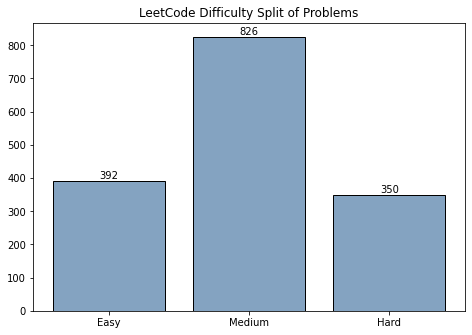

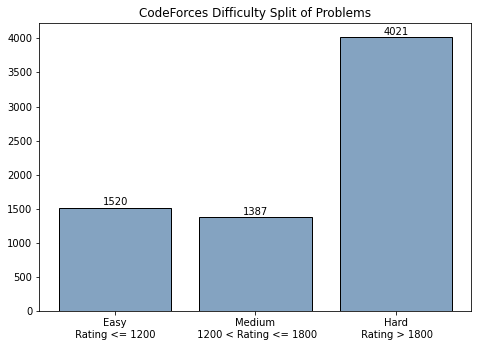

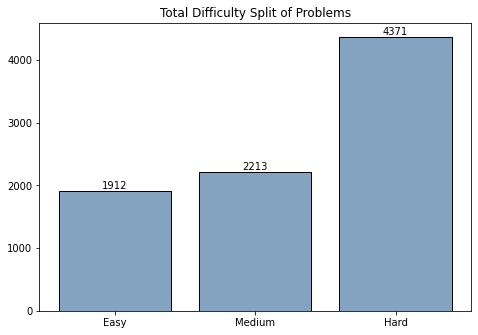

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
difficulty = ["Easy", "Medium", "Hard"]
counts = []
for i in count:
  counts.append(count_lc[i])
bars1 = ax.bar(difficulty,counts,color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
ax.set_title("LeetCode Difficulty Split of Problems")
for bar in bars1: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
difficulty = ["Easy\n Rating <= 1200 ", "Medium\n 1200 < Rating <= 1800", "Hard\n Rating > 1800"]
counts = []
for i in count:
  counts.append(count_cf[i])
bars2 = ax.bar(difficulty,counts,color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
ax.set_title("CodeForces Difficulty Split of Problems")
for bar in bars2: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
difficulty = ["Easy", "Medium", "Hard"]
counts = []
for i in count:
  counts.append(count[i])
bars3 = ax.bar(difficulty,counts,color=(0.2, 0.4, 0.6, 0.6),edgecolor='black')
ax.set_title("Total Difficulty Split of Problems")
for bar in bars3: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.show()

#### Titles

In [ ]:
bow = {}
for i in range(len(df_combined)):
  for word in df_combined.iloc[i]['title'].split(' '):
    if word not in bow:
      bow[word] = 1
    else:
      bow[word]+=1

In [ ]:
freq = []
for i in bow:
  hq.heappush(freq, (bow[i], i))

print(hq.nlargest(20, freq))
print(hq.nsmallest(4, freq))

[(1390, 'and'), (613, 'of'), (406, 'the'), (326, 'a'), (261, 'Number'), (248, 'in'), (239, 'Array'), (235, 'The'), (233, 'Tree'), (220, 'to'), (197, 'Game'), (188, 'String'), (176, 'Sum'), (162, 'Maximum'), (157, 'Two'), (147, 'Binary'), (145, 'Minimum'), (126, 'Numbers'), (107, 'Problem'), (105, 'version)')]
[(1, '!='), (1, '"Or"'), (1, '#NAME?'), (1, '&amp;')]


<Figure size 5760x7200 with 0 Axes>

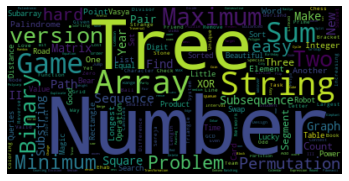

<Figure size 5760x7200 with 0 Axes>

In [ ]:
text = ''
for i in bow:
  for j in range(bow[i]):
    text+=(" " + i)
word_cloud = WordCloud(collocations=False).generate(text)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.figure(figsize=[80,100])


#### Problem Description

[(87482, 'the'), (47574, 'of'), (34574, 'to'), (28856, 'is'), (28246, 'a'), (25962, 'and'), (18572, 'in'), (16201, 'that'), (14391, 'are'), (14139, ''), (9021, 'number'), (8611, 'can'), (8547, 'from'), (8342, 'be'), (7756, 'with'), (7445, 'one'), (7209, 'if'), (6932, 'each'), (6873, 'he'), (6855, 'for')]


<Figure size 5760x7200 with 0 Axes>

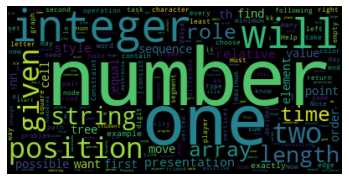

<Figure size 5760x7200 with 0 Axes>

In [ ]:
bow = {}
for i in range(len(df_combined)):
  for word in df_combined.iloc[i]['description'].split(' '):
    if word not in bow:
      bow[word] = 1
    else:
      bow[word]+=1
freq = []
for i in bow:
  hq.heappush(freq, (bow[i], i))

print(hq.nlargest(20, freq))

text = ''
for i in bow:
  for j in range(bow[i]):
    text+=(" " + i)
word_cloud = WordCloud(collocations=False).generate(text)
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.figure(figsize=[80,100])

#### Problem Topics

In [ ]:
# Create map of unique topics and their frequencies

###unique_topics = df_combined['topics'].unique()
unique_topic_count = {}
###for entry in unique_topics:
for i in range(len(df_combined)):
  entry = df_combined.iloc[i]['topics']
  if isinstance(entry, str):
    topics = entry.split(', ')
    for topic in topics:
      if topic[0] == ' ':
        if topic[1:] in unique_topic_count:
          unique_topic_count[topic[1:].lower()] += 1
        else:
          unique_topic_count[topic[1:].lower()] = 1
      else:
        if topic in unique_topic_count:
          unique_topic_count[topic.lower()] += 1
        else:
          unique_topic_count[topic.lower()] = 1

print(unique_topic_count.keys())
print(len(unique_topic_count))

dict_keys(['array', 'hash table', 'linked list', 'math', 'recursion', 'string', 'sliding window', 'binary search', 'dynamic programming', 'two pointers', 'greedy', 'sorting', 'backtracking', 'stack', 'string matching', 'bit manipulation', 'matrix', 'monotonic stack', 'simulation', 'combinatorics', 'memoization', 'tree', 'depth-first search', 'binary tree', 'binary search tree', 'breadth-first search', 'union find', 'graph', 'trie', 'design', 'doubly-linked list', 'geometry', 'bucket sort', 'radix sort', 'iterator', 'rolling hash', 'hash function', 'enumeration', 'number theory', 'topological sort', 'prefix sum', 'ordered set', 'queue', 'counting', 'heap (priority queue)', 'monotonic queue', 'counting sort', 'interactive', 'brainteaser', 'game theory', 'data stream', 'binary indexed tree', 'segment tree', 'eulerian circuit', 'randomized', 'reservoir sampling', 'line sweep', 'shortest path', 'bitmask', 'probability and statistics', 'rejection sampling', 'suffix array', 'biconnected compo

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Top 10 topic tags:
 ['implementation', 'math', 'greedy', 'dynamic programming', 'data structures', 'brute force', 'constructive algorithms', 'graphs', 'sortings', 'binary search']


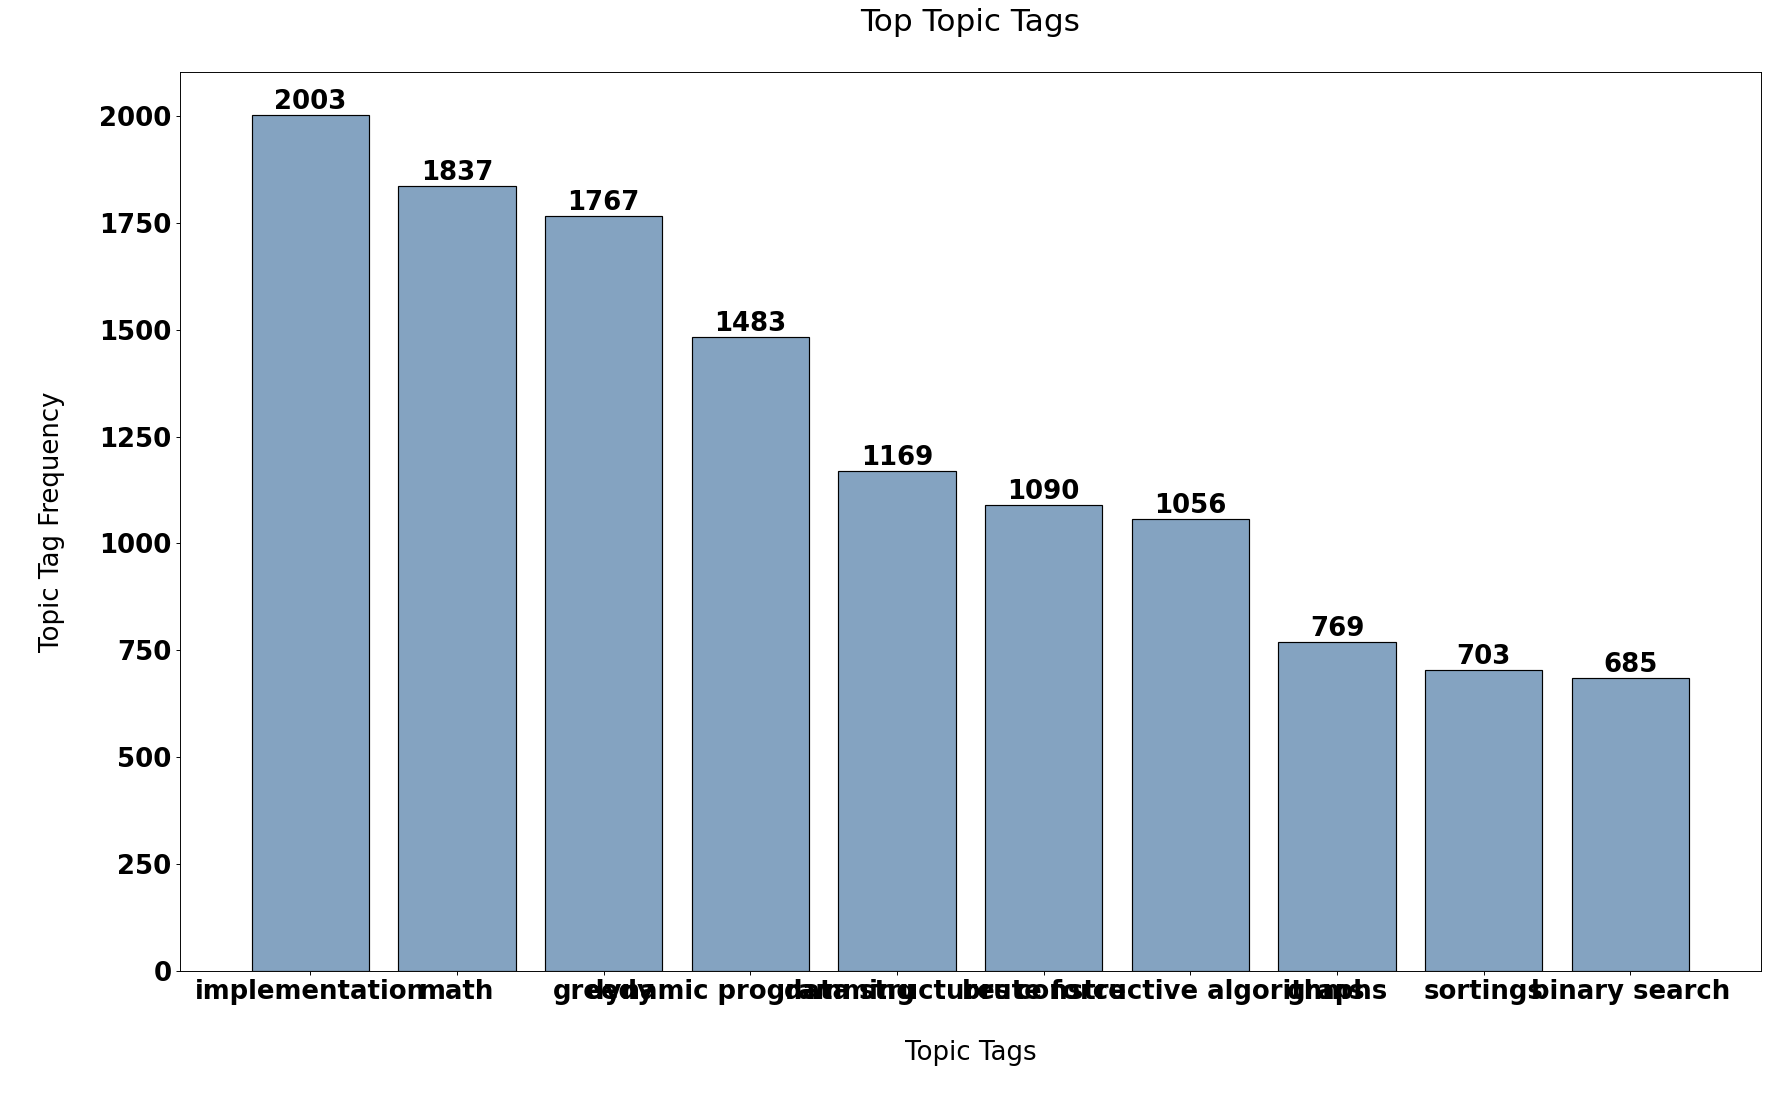

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

top_10_topics = sorted(unique_topic_count, key=unique_topic_count.get, reverse=True)[:10]
print("Top 10 topic tags:\n", top_10_topics)

top_10_frequencies = [unique_topic_count[topic] for topic in top_10_topics]
fig1, ax1 = plt.subplots(figsize=(24,14), dpi=85)
bars1 = ax1.bar(top_10_topics, top_10_frequencies, edgecolor='black', color=(0.2, 0.4, 0.6, 0.6))
ax1.set_xlabel("\nTopic Tags\n")
ax1.set_ylabel("\nTopic Tag Frequency\n")
ax1.set_title("Top Topic Tags\n")
for bar in bars1: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax1.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.savefig("top10tags.png", bbox_inches="tight", transparent=True)


#### Run Times

runtime                
n                          750
1                          144
nlog(n)                     98
n^2                         79
nm                          60
                          ... 
n*k*max(balls)               1
n*m*log(n)                   1
n*m*target                   1
n*max(nums)+q*max(nums)      1
(log n)^2                    1
Length: 157, dtype: int64 


Top 10 runtimes:
 ['n', '1', 'nlog(n)', 'n^2', 'nm', 'log(n)', 'n^3', 'n+m', 'k', '2^n'] 




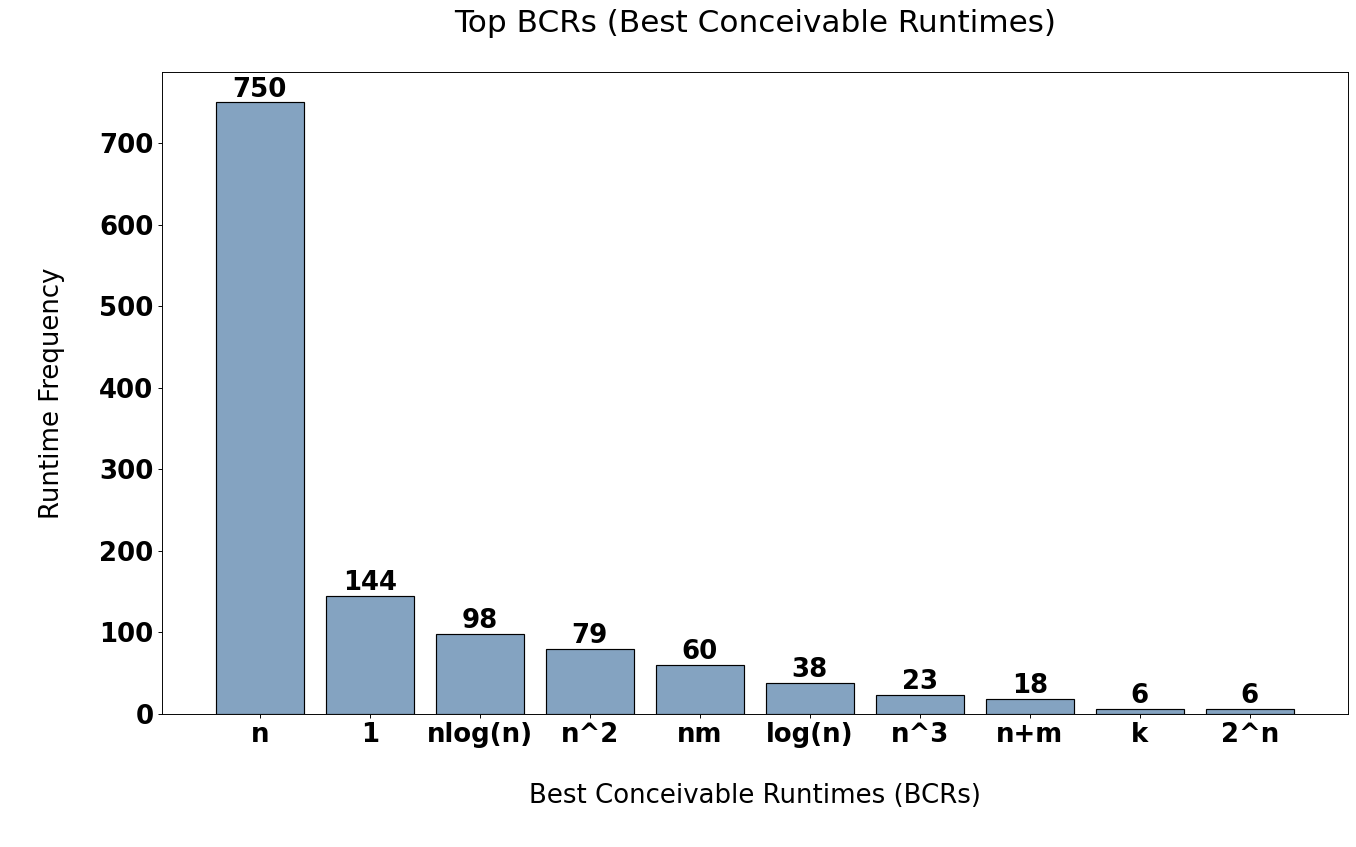

In [ ]:
# Create map of unique runtimes and their frequencies
unique_runtimes = df_combined.value_counts(subset=['runtime'])
print(unique_runtimes, "\n\n")
top_10_runtimes = [runtime[0] for runtime in unique_runtimes.index[:10]]
print("Top 10 runtimes:\n", top_10_runtimes, "\n\n")

top_10_frequencies = list(unique_runtimes[:10])
fig1, ax1 = plt.subplots(figsize=(18,10), dpi=85)
bars1 = ax1.bar(top_10_runtimes, top_10_frequencies, edgecolor='black', color=(0.2, 0.4, 0.6, 0.6))
ax1.set_xlabel("\nBest Conceivable Runtimes (BCRs)\n")
ax1.set_ylabel("\nRuntime Frequency\n")
ax1.set_title("Top BCRs (Best Conceivable Runtimes)\n")
for bar in bars1: #labels
  x_pos = bar.get_x() + bar.get_width() / 2
  height = bar.get_height()
  ax1.text(x_pos, height + .25, s=round(height,3), ha='center', va='bottom')
plt.savefig("top10runtimes.png", bbox_inches="tight", transparent=True)


### Embeddings

#### Word2Vec

In [ ]:
#https://code.google.com/archive/p/word2vec/
import gensim.downloader as api

def download_word2vec_embeddings():
    print("Downloading pre-trained word embeddings from: word2vec-google-news-300.\n" 
          + "Note: This can take a few minutes.\n")
    wv = api.load("word2vec-google-news-300")
    print("\nLoading complete!\n")
    return wv

word_vector_model = download_word2vec_embeddings()

Note: This can take a few minutes.

[==================================================] 100.0% 1662.8/1662.8MB downloaded

Loading complete!



In [ ]:
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string

def filter_words_not_in_model(sequence):
    for i in range(len(sequence)):
      if sequence[i] not in word_vector_model:
        sequence.pop(i)
        i -= 1
    return sequence

df_copy = df_combined.copy()
df_copy['description'] = df_copy['description'].apply(lambda x: x.split())
df_copy['description'] = df_copy['description'].map(lambda x: list(filter(lambda w: w in word_vector_model, x)))
df_copy['description'] = df_copy['description'].map(lambda x: [word_vector_model[w] for w in x])

In [ ]:
df_copy.iloc[0]

Unnamed: 0                            0
id                                    1
title                           Two Sum
title_slug                      two-sum
difficulty                            1
description    [[-0.10888672, 0.1875...
topics                Array, Hash Table
runtime                               n
Name: 0, dtype: object

### Upsampling

We will be upsampling using SMOTE, which uses K-Means clustering to generate synthetic datapoints for the minority classes.

In [ ]:
# SMOTE oversampling on training data
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
df_copy['runtime'].fillna('', inplace=True)
df_copy['runtime'] = vectorizer.fit_transform(df_copy['runtime'])
df_copy['title'] = vectorizer.fit_transform(df_copy['title'])
df_copy.drop(['title_slug'], axis=1, inplace=True)

sm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # test k_neighbors=1-5
print(df_copy.iloc[0])
smote_upsampled_df, smote_labels = sm.fit_resample(df_copy, df_copy['runtime'])

[<8496x76 sparse matrix of type '<class 'numpy.int64'>'
	with 353 stored elements in Compressed Sparse Row format>
 <8496x76 sparse matrix of type '<class 'numpy.int64'>'
	with 353 stored elements in Compressed Sparse Row format>
 <8496x76 sparse matrix of type '<class 'numpy.int64'>'
	with 353 stored elements in Compressed Sparse Row format>
 ...
 <8496x76 sparse matrix of type '<class 'numpy.int64'>'
	with 353 stored elements in Compressed Sparse Row format>
 <8496x76 sparse matrix of type '<class 'numpy.int64'>'
	with 353 stored elements in Compressed Sparse Row format>
 <8496x76 sparse matrix of type '<class 'numpy.int64'>'
	with 353 stored elements in Compressed Sparse Row format>]


AttributeError: ignored

#### BERT

In [ ]:
# used this guide: https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

"""
Converts a string sentence to tensor of BERT embeddings
Meant to be used with df.apply() where you feed in df['description'] as the input
"""
def convert_text_to_embeddings(sequence):
  # tokenize sentence and get hidden states
  inputs = tokenizer(sequence, return_tensors="pt")
  outputs = model(**inputs, output_hidden_states=True)

  # reshape and permute hidden states
  token_embeddings = torch.stack(list(outputs[2]), dim=0)
  token_embeddings = torch.squeeze(token_embeddings, dim=1)
  token_embeddings = token_embeddings.permute(1,0,2)

  # concatenate the last 4 hidden states to create token embeddings
  last_4_cat_embeddings = []
  for token in token_embeddings:
    final_embedding = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    last_4_cat_embeddings.append(final_embedding.view(1, -1))

  last_4_cat_embeddings = torch.stack(last_4_cat_embeddings, dim=0)
  return last_4_cat_embeddings

In [ ]:
from transformers import BertTokenizer, BertModel

def generate_BERT_embeddings(df: 'DataFrame', tokenizer_name='bert-base-uncased', model_name='bert-base-uncased'):
  tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
  model = BertModel.from_pretrained(model_name, output_hidden_states=True)

  device = torch.device('cuda')
  model.to(device)
  text = df.description.values

  attention_masks = []

  tokens = []

  print("Tokenizing:")
  for p in tqdm(text): 
    #tokens_dict = tokenizer.encode_plus(p, add_special_tokens=True, truncation=True, return_attention_mask=True, return_tensors='pt', padding='max_length')

    # encode_plus is deprecated, use __call__
    # https://huggingface.co/transformers/internal/tokenization_utils.html#transformers.tokenization_utils_base.PreTrainedTokenizerBase.encode_plus 
    tokens_dict = tokenizer(p, add_special_tokens=True, truncation=True, return_attention_mask=True, return_tensors='pt', padding='max_length') 
    tokens.append(tokens_dict['input_ids'])
    attention_masks.append(tokens_dict['attention_mask'])
  print(tokens_dict)
  tokens = torch.cat(tokens, dim=0).to(device) #Reformatting for correct shape
  print(tokens.shape)
  attention_masks = torch.cat(attention_masks, dim=0).to(device)
  if tokens.shape[0] != attention_masks.shape[0]:
    print("Something went wrong")

  model.eval()

  with torch.no_grad():
    hidden_states = torch.tensor([]).to(device)
    print("Embedding:")
    for i in tqdm(range(int(len(tokens) / 64) + 1)):
      start = 64*i
      end = min(64*(i+1), len(tokens))
      output = model(tokens[start:end])
      if not len(hidden_states):
        hidden_states = output[2][-1]
      else:
        hidden_states = torch.cat((hidden_states, output[2][-1]))
    return hidden_states, attention_masks

#### RoBERTa

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# use convert_text_to_embeddings method from above

In [ ]:
# from transformers import RobertaTokenizer, RobertaModel

# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
# tokens = []

# for p in text: 
#   tokens_dict = tokenizer.encode_plus(p, add_special_tokens=True, return_attention_mask=True, return_tensors='pt', padding='max_length')
#   tokens.append(tokens_dict['input_ids'])

# tokens = torch.cat(tokens, dim=0) #Reformatting for correct shape

# model.eval()

# with torch.no_grad():
#   output = model(tokens)
#   hidden_states = output[2]

# Roberta_embeddings = hidden_states[-1]
# print(Roberta_embeddings.shape)
# # print(BERT_embeddings[0][0])

#### FastText for Domain-Specific Embeddings

##Clustering

###KNN on Runtime

## Classification Model Training

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

### Utilities

#### Testing/Training Loops

In [ ]:
def loss(model, loss_fn, x, y, pre_trained, seq_len, device='cpu'):
    """
    Helper function to calculate loss for a set of samples
    :param model: model to use for the forward pass
    :param loss_fn: loss function to apply
    :param x: samples in
    :param y: labels out
    :param pre_trained: are we passing in embeddings or indices? Boolean: true for embeddings
    :param seq_len: sequence length
    :param device: device to put tensors on
    :return: torch loss value, accuracy number, and length of x (for reporting)
    """

    # If the length of x is not evenly divisible by your sequence length, need to fit the data somehow
    # Either remove trailing data, or (if x is too small), just set sequence-length to the length of x
    if len(x) % seq_len != 0:
        if len(x) < seq_len:
            seq_len = len(x)
        remainder = len(x) % seq_len
        if remainder % seq_len != 0:
          x = x[:-remainder]
          y = y[:-remainder]

    # If we have embeddings going in, reshape to the batch x sequence x embed size
    # Else, just flatten into batches x seq_len (and cast to long)
    # cast labels to long and put everything on the right device
    # Pass through model, get loss with loss_fun, get accuracy from predictions,
    ### YOUR CODE GOES HERE
    old_x = x
    # x, y = torch.Tensor(x).to(device), torch.Tensor(y).to(device)
    if pre_trained:
        x = x.view(-1, seq_len, model.embedding_dim)
    else:
        x = x.view(-1, seq_len)
    x = x.float()
    pred = model(x)
    # flatten = len(pred)
    # pred = pred.view(seq_len * len(pred), -1).float()
    # y = y.view(seq_len * flatten).long()
    pred = pred.float().to(device)
    y = y.type(torch.LongTensor).to(device)
    #print(pred.shape, y.shape)
    loss_value = loss_fn(pred, y)
    pred = torch.argmax(pred, dim=1)
    accuracy_value = torch.sum(torch.eq(pred, y)).item()
    x = old_x
    ### YOUR CODE ENDS HERE
    return loss_value, accuracy_value, len(x)


def train_loop(model, optimizer, loss_fn, samples, labels,
               batch_size, seq_len, device='cpu', pre_trained=False):
    """
    Standard pytorch training loop, using our helper loss function above.
    :param model: model to optimize
    :param optimizer: optimizer
    :param loss_fn: loss function
    :param samples: data in
    :param labels: labels out
    :param batch_size: batch size for sequences
    :param seq_len: sequence length
    :param device: device to put tensors on
    :param pre_trained: are we using pre-made embeddings or passing in indices?
    :return: model, loss, and accuracy
    """
    loss_total = 0
    acc_total = 0
    total_samples = 0
    # iterate through all samples, stepping by batch_size * sequence length and using
    # your loss function above to calculate loss. Then, zero gradients, backprop, step optimizer, and repeat
    # Also, store up the loss total, total number correct, and total number processed by the model so far

    for i in range(0, len(samples), batch_size):
        ### YOUR CODE GOES HERE (delete the continue)
        model.zero_grad()
        pred = samples[i:min(i+batch_size, len(samples))]
        batch_labels = labels[i:min(i+batch_size, len(samples))]
        loss_val, acc_val, len_x = loss(model, loss_fn, pred, batch_labels, pre_trained, seq_len, device=device)
        loss_total += loss_val.item()
        acc_total += acc_val
        total_samples += len_x
        loss_val.backward()
        optimizer.step()

        ### YOUR CODE ENDS HERE
    # Return model, loss, and accuracy
    return model, loss_total, acc_total/total_samples


def val_loop(model, loss_fn, samples, labels, batch_size, seq_len, device='cpu', pre_trained=False):
    """
    Standard pytorch validation loop, using our helper loss function above
    :param model: model to test
    :param loss_fn: loss function to evaluate with
    :param samples: data in
    :param labels: labels out
    :param batch_size: batch size
    :param seq_len: sequence length
    :param device: device to put tensors on
    :param pre_trained: are we using pre-trained embeddings or indices?
    :return: loss and accuracy for evaluation
    """
    loss_total = 0
    acc_total = 0
    total_samples = 0
    with torch.no_grad():
        # Again, step through data taking batch_size*sequence_length sized steps
        # For each step, use your helper loss function to get a loss value and accuracy total
        # DO NOT STEP THE OPTIMIZER OR BACKPROP THE LOSS
        for i in range(0, len(samples), batch_size):
            ### YOUR CODE GOES HERE (delete the continue)
            pred = samples[i:min(i+batch_size, len(samples))]
            batch_labels = labels[i:min(i+batch_size, len(samples))]
            loss_val, acc_val, len_x = loss(model, loss_fn, pred, batch_labels, pre_trained, seq_len, device=device)
            loss_total += loss_val.item()
            acc_total += acc_val
            total_samples += len_x
            ### YOUR CODE ENDS HERE
    # Return loss and accuracy
    return loss_total, acc_total/total_samples

#### LSTM

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self,
                 vocab_size,
                 embedding_dim,
                 use_embeds,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional):
    super().__init__()
    self.use_embeds = use_embeds
    self.bidirectional = bidirectional
    self.embedding_dim = embedding_dim
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, bidirectional=bidirectional, batch_first=True)
    self.linear = nn.Linear(hidden_dim, output_dim)
    self.linear_bidirectional = nn.Linear(hidden_dim*2, output_dim)
  def forward(self, data_in):
    # if not self.use_embeds:
    #     data_in = self.embedding(data_in)
    #print('embedding', data_in.shape)
    data_in = data_in.reshape((data_in.shape[1],512,768))
    _, (data_in, _) = self.lstm(data_in)
    #print('lstmout', data_in.shape)
    if self.bidirectional:
        data_in = torch.cat((data_in[0], data_in[1]), dim=1)
        #print('lstmout', data_in.shape)
        data_in = self.linear_bidirectional(data_in)
    else:
        data_in = self.linear(data_in)
    #print('linout', data_in.shape)
    ### YOUR CODE ENDS HERE
    return data_in

### Category Model

In [ ]:
# Category Model
df_lc.keys()

### Difficulty Model

#### Logistic Regression

In [ ]:
# Difficulty Model
X, attention_masks = generate_BERT_embeddings(df_lc)
y = df_lc.difficulty.values

In [ ]:
X = X.to(torch.device('cpu'))
attention_masks = torch.unsqueeze(attention_masks, 2)
attention_masks = attention_masks.to(torch.device('cpu'))
print(X.shape)
print(attention_masks.shape)
# print(attention_masks[0])

In [ ]:
# X = torch.mean(X, dim=1)
attention_masks = torch.tensor(attention_masks)
X_attention = X*attention_masks
print(f"1: {X_attention.shape}")
X_attention = torch.sum(X_attention,axis=1)
print(f"2: {X_attention.shape}")
attention_sums = torch.sum(attention_masks, axis=1)
print(f"3: {attention_sums.shape}")
X_in = X_attention/attention_sums
# X_in = torch.tensor([])
# for i in range(len(X_attention)):
#   X_in.append(torch.sum(X_attention[i])/torch.sum(tokens_dict['attention_masks'][i]))

X_in.shape

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

#trying Raj's BERT
X_in = df['description'].apply(lambda x: convert_text_to_embeddings(x))

# nsamples, nx, ny = X.shape
# X2 = X.reshape((nsamples,nx*ny))
x_train, x_test, y_train, y_test = train_test_split(X_in, y, test_size=0.2)
print(f"XTrain: {x_train.shape}, XTest: {x_test.shape}")
print(f"YTrain: {y_train.shape}, YTest: {y_test.shape}")
# x_train, y_train = x_train.to(torch.device('cpu')), y_train.to(torch.device('cpu'))

fine_grid = [0.05, 0.01, 0.005, 0.001]
grid = [10, 1, 0.1, 0.01, 0.001]
for i in grid:
  lr = LogisticRegression(C=i,class_weight='balanced', max_iter=1000, penalty='l2')
  lr.fit(x_train, y_train)
  print(i, '\n')
  print(lr.predict(x_train[0:20]), '\n')
  print(lr.score(x_train, y_train), '\n')
  print(lr.score(x_test, y_test), '\n')
  print(roc_auc_score(y_test, lr.predict_proba(x_test), multi_class='ovo'))

#### LSTM

In [ ]:
#Hyperparams
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)
BATCH_SIZE = 8
SEQ_LEN = 512
NUM_EPOCHS = 15
PRE_TRAINED = True
BIDIRECTIONAL = True
SHUFFLE=False
hidden_dim = 64
num_layers = 1
embed_dim = 768
bow = set()
output_size=3

for i in range(len(df_lc)):
  for word in df_lc.iloc[i]['description'].split(' '):
    bow.add(word)
vocab_size = len(bow)


In [ ]:
X, attention_masks = generate_BERT_embeddings(df_lc)
y = df_lc.difficulty.values - 1

In [ ]:
#7/1/2 train/val/test split
# DEVICE = torch.device("cpu")
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
x_train, x_val, y_val, y_test = train_test_split(x_train, y_train, test_size=0.125)
x_train, y_train, x_val, y_val, x_test, y_test = torch.tensor(x_train), torch.tensor(y_train), torch.tensor(x_val), torch.tensor(y_val), torch.tensor(x_test), \
  torch.tensor(y_test)
x_train, y_train, x_val, y_val, x_test, y_test = x_train.float(), y_train.float(), x_val.float(), y_val.float(), x_test.float(), y_test.float()
x_train, y_train, x_val, y_val, x_test, y_test = x_train.to(DEVICE), y_train.to(DEVICE), x_val.to(DEVICE), y_val.to(DEVICE), x_test.to(DEVICE), y_test.to(DEVICE)
print(f"XTrain: {x_train.shape}, YTrain: {y_train.shape}")
print(f"XVal: {x_val.shape}, YVal: {y_val.shape}")
print(f"XTest: {x_test.shape}, YTest: {y_test.shape}")
DEVICE = torch.device("cuda:0")
model = LSTMModel(vocab_size=vocab_size,
        embedding_dim=embed_dim,
        use_embeds=PRE_TRAINED,
        hidden_dim=hidden_dim,
        output_dim=output_size,
        n_layers=num_layers,
        bidirectional=BIDIRECTIONAL,
    ).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=.05) # Optimizer of your choice
criterion = torch.nn.CrossEntropyLoss()# Loss function of your choice, but cross entropy or negative log likelihood are probably the best bets!
### END YOUR CODE
training_metrics = {'loss': [], 'acc': []}
testing_metrics = {'loss': [], 'acc': []}
    

In [ ]:
for _ in range(NUM_EPOCHS):
  ### YOUR CODE GOES HERE (determine what to pass to train_loop)
  model, loss_total, acc_total = train_loop(model, opt, criterion, x_train, y_train, BATCH_SIZE, SEQ_LEN, device=DEVICE, pre_trained=PRE_TRAINED)
  ### YOUR CODE ENDS HERE
  training_metrics['loss'].append(loss_total)
  training_metrics['acc'].append(acc_total)
  print(f"Training loss: {loss_total} || Training Accuracy: {acc_total}")
  ### YOUR CODE GOES HERE (determine what to pass to val_loop)
  loss_total, acc_total = val_loop(model, criterion, x_val, y_val, BATCH_SIZE, SEQ_LEN, device=DEVICE, pre_trained=PRE_TRAINED)
  ### YOUR CODE ENDS HERE
  testing_metrics['loss'].append(loss_total)
  testing_metrics['acc'].append(acc_total)
  print(f"Validation loss: {loss_total} || Validation Accuracy: {acc_total}")

### Runtime Model with Logistic Regression, TF-IDF, and SMOTE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score

df_lc_no_nan = df_lc.drop(columns=['title_slug', 'description', 'topics'])
df_lc_no_nan['topics'] = df_lc['topics'].fillna('')
df_lc_no_nan['description'] = df_lc['description'].fillna('')
df_lc_no_nan = df_lc_no_nan[df_lc_no_nan['runtime'].notna()]

pd.set_option("display.max_rows", None)
print(df_lc_no_nan['runtime'].value_counts()[:5])
total_rows = df_lc_no_nan[df_lc_no_nan.columns[0]].count()

#filtering to top 5 runtimes
top_5_runtimes = ['n', '1', 'nlog(n)', 'n^2', 'nm']
print(f"\nTotal number of data points: {total_rows}")
df_lc_no_nan = df_lc_no_nan.loc[df_lc_no_nan['runtime'].isin(top_5_runtimes)]

train_data, test_data = train_test_split(df_lc_no_nan, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

# tfidf on train data
tfidf_vect_description = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=1000)
train_x = tfidf_vect_description.fit_transform(train_data['description'])
train_labels = train_data['runtime']

# SMOTE oversampling on training data
sm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # 3 k_neighbors works best, tested 1-5
train_x, train_labels = sm.fit_resample(train_x, train_labels)

# tfidf on val data
val_x = tfidf_vect_description.transform(val_data['description'])
val_labels = val_data['runtime']

# tfidf on test data
test_x = tfidf_vect_description.transform(test_data['description'])
test_labels = test_data['runtime']

#I use fit_transform instead of fit, not sure why

In [ ]:
import eli5

log_reg = LogisticRegression(multi_class='multinomial', max_iter=100, random_state=0)
log_reg.fit(train_x, train_labels)
pred_val_y = log_reg.predict(val_x)
print(pred_val_y)
print(accuracy_score(val_labels, pred_val_y))
print(f1_score(val_labels, pred_val_y, average='macro'))
eli5.show_weights(estimator=log_reg, feature_names= list(tfidf_vect_description.get_feature_names()),top=(50))

### Difficulty Model with Logistic Regression, TF-IDF, and SMOTE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

df_lc_no_nan = df_lc.drop(columns=['title_slug', 'description', 'topics'])
df_lc_no_nan['topics'] = df_lc['topics'].fillna('')
df_lc_no_nan['description'] = df_lc['description'].fillna('')
df_lc_no_nan = df_lc_no_nan[df_lc_no_nan['runtime'].notna()]

pd.set_option("display.max_rows", None)
print(df_lc_no_nan['runtime'].value_counts()[:5])
print(df_lc_no_nan.columns)
total_rows = df_lc_no_nan[df_lc_no_nan.columns[0]].count()

train_data, test_data = train_test_split(df_lc_no_nan, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

# tfidf on train data
tfidf_vect_description = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=1000)
train_x = tfidf_vect_description.fit_transform(train_data['description'])
train_labels = train_data['difficulty']

# SMOTE oversampling on training data
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # test k_neighbors=1-5
train_x, train_labels = sm.fit_resample(train_x, train_labels)

# tfidf on val data
val_x = tfidf_vect_description.transform(val_data['description'])
val_labels = val_data['difficulty']

# tfidf on test data
test_x = tfidf_vect_description.transform(test_data['description'])
test_labels = test_data['difficulty']

#I use fit_transform instead of fit, not sure why

In [ ]:
import eli5

log_reg = LogisticRegression(multi_class='multinomial', max_iter=100, random_state=0)
log_reg.fit(train_x, train_labels)
pred_val_y = log_reg.predict(val_x)
print(pred_val_y)
print(accuracy_score(val_labels, pred_val_y))
print(f1_score(val_labels, pred_val_y, average='macro'))
eli5.show_weights(estimator=log_reg, feature_names= list(tfidf_vect_description.get_feature_names()),top=(50))

### Topic Model with Logistic Regression, TF-IDF, and SMOTE

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

df_lc_no_nan = df_lc.drop(columns=['title_slug', 'description', 'topics'])
df_lc_no_nan['topics'] = df_lc['topics'].fillna('')
df_lc_no_nan['description'] = df_lc['description'].fillna('')
df_lc_no_nan = df_lc_no_nan[df_lc_no_nan['runtime'].notna()]

pd.set_option("display.max_rows", None)
print(df_lc_no_nan['topics'].head(5))
print(df_lc_no_nan.columns)
total_rows = df_lc_no_nan[df_lc_no_nan.columns[0]].count()

#filtering to top 10 topics
#top_10_topics = ['implementation', 'math', 'greedy', 'dynamic programming', 'data structures', 'brute force', 'constructive algorithms', 'graphs', 'sortings', 'binary search']
#print(f"\nTotal number of data points: {total_rows}")
#df_lc_no_nan = df_lc_no_nan.loc[df_lc_no_nan['topics'].isin(top_10_topics)]

train_data, test_data = train_test_split(df_lc_no_nan, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

# tfidf on train data
tfidf_vect_description = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=1000)
train_x = tfidf_vect_description.fit_transform(train_data['description'])
train_labels = train_data['topics']

# SMOTE oversampling on training data
#sm = SMOTE(sampling_strategy='not majority', k_neighbors=3, random_state=0) # 3 k_neighbors works best, tested 1-5
#train_x, train_labels = sm.fit_resample(train_x, train_labels)

# tfidf on val data
val_x = tfidf_vect_description.transform(val_data['description'])
val_labels = val_data['topics']

# tfidf on test data
test_x = tfidf_vect_description.transform(test_data['description'])
test_labels = test_data['topics']

#I use fit_transform instead of fit, not sure why

In [ ]:
import eli5

log_reg = LogisticRegression(multi_class='multinomial', max_iter=100, random_state=0)
log_reg.fit(train_x, train_labels)
pred_val_y = log_reg.predict(val_x)
print(pred_val_y)
print(accuracy_score(val_labels, pred_val_y))
print(f1_score(val_labels, pred_val_y, average='macro'))
eli5.show_weights(estimator=log_reg, feature_names= list(tfidf_vect_description.get_feature_names()),top=(50))

## Clustering Model Training

## Question Generation

In [3]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer

#Implementation of text generation with GPT Neo:
model = GPTNeoForCausalLM.from_pretrained('EleutherAI/gpt-neo-1.3B')
tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-1.3B')





Downloading: 100%|██████████| 1.32k/1.32k [00:00<00:00, 337kB/s]
Downloading: 100%|██████████| 4.95G/4.95G [07:24<00:00, 11.9MB/s]
Downloading: 100%|██████████| 779k/779k [00:00<00:00, 6.73MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 3.40MB/s]
Downloading: 100%|██████████| 90.0/90.0 [00:00<00:00, 45.0kB/s]
Downloading: 100%|██████████| 200/200 [00:00<00:00, 200kB/s]
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [5]:
prompt = "Here is a coding problem about binary search trees.\n"

input_ids = tokenizer(prompt, return_tensors='pt').input_ids
gen_tokens = model.generate(input_ids=input_ids, max_length=400, temperature=0.7, repetition_penalty=2.5)
gen_text = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(gen_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Here is a coding problem about binary search trees.

I have a binary search tree with n nodes. I want to find the minimum value of the tree.

The problem is that I don't know how to do this in C++. I tried to use std::min_element but it doesn't work.

A:

You can use std::min_element, which is a member function of std::unordered_set.
#include <iostream>
#include <vector>
#include <algorithm>
#include <iterator>
#include <numeric>

int main() {
    std::vector<int> v{1, 2, 3, 4, 5};
    std::unordered_set<int> u;
    for (auto i : v) {
        if (u.find(i) == u.end()) {
            std::cout << "Value " << i << " is not in the set." << std::endl;
        } else {
            auto min = u.min();
            std::cout << "Value " << i << " is in the set." << std::endl;
            u.insert(i);
            std::cout << "Value " << i << " is now in the set." << std::endl;
        }
    }
}

Output:
Value 1 is not in the set.
Value 2 is in the set.
Value 3
